In [4]:
#@title Install required packages
!pip install -Uq datasets

In [5]:
#@title Import packages

import os
os.environ["TRANSFORMERS_VERBOSITY"]="error"

import torch
import random
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    PaliGemmaProcessor,
    PaliGemmaForConditionalGeneration,
)
from functools import partial
from tqdm import tqdm
from matplotlib import pyplot as plt

In [6]:
#@title # Util functions
def collate_fn(examples, processor):
    images = list()
    prompt = list()
    suffix = list()
    for sample in examples:
        images.append(sample["image"].convert("RGB"))
        suffix.append(str(sample["label"]))
        prompt.append("count intersection")

    inputs = processor(
        images=images,
        text=prompt,
        suffix=suffix,
        return_tensors="pt",
    )
    inputs = inputs.to(torch.bfloat16)
    return inputs

def freeze_layers(model):
    for name, param in model.named_parameters():
        if "attn" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    return model

def run_inference(val_dataset, processor, model):
    # infer before training
    val_sample = random.choice(val_dataset)
    image = val_sample["image"].convert("RGB")
    inputs = processor(
        images = [image],
        text = ["count intersection"],
        return_tensors="pt",
    ).to(torch.bfloat16)
    input_len = inputs["input_ids"].shape[-1]
    with torch.no_grad():
        generation = model.generate(**inputs.to(model.device), max_new_tokens=10)
        generation = generation[0][input_len:]
        decoded = processor.decode(generation, skip_special_tokens=True)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {decoded}")
    plt.show()

In [7]:
#@title Login to Huggingface Hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `px` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `px`


In [9]:
#@title # Load dataset and pretrained model

ckpt_id = "google/paligemma2-3b-pt-224"
dataset_id = "ariG23498/intersection-dataset"


# load the dataset and the processor
print(f"[INFO] Loading {ckpt_id} processor")
processor = PaliGemmaProcessor.from_pretrained(ckpt_id)

# load the dataset
print(f"[INFO] Loading {dataset_id} dataset")
train_dataset = load_dataset(dataset_id, split="train")
val_dataset = load_dataset(dataset_id, split="validation")

# create data loader
print(f"[INFO] Creating dataloader")
partial_collate_fn = partial(collate_fn, processor=processor)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    collate_fn=partial_collate_fn,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    collate_fn=partial_collate_fn,
)

# load the model and optimizer
print(f"[INFO] Loading {ckpt_id} model")
model = PaliGemmaForConditionalGeneration.from_pretrained(
    ckpt_id, torch_dtype=torch.bfloat16, device_map="auto"
)

[INFO] Loading google/paligemma2-3b-pt-224 processor
[INFO] Loading ariG23498/intersection-dataset dataset


train-00000-of-00001.parquet:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

[INFO] Creating dataloader
[INFO] Loading google/paligemma2-3b-pt-224 model


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

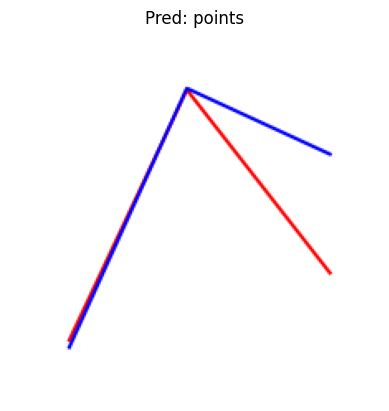

[INFO] Model loaded on cuda:0


0it [00:00, ?it/s]

Iter: 0 Loss: 0.3309 Val Loss: 2.5329


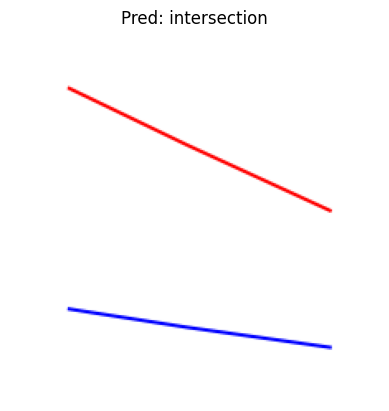

0it [03:45, ?it/s]


In [11]:
#@title # Fine-tuning loop using transformers

# run inference before training
run_inference(val_dataset, processor, model)

model = freeze_layers(model)
print(f"[INFO] Model loaded on {model.device}")
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,
)

# Start Training
accumulation_steps = 8
for idx, batch in tqdm(enumerate(train_dataloader)):
    outputs = model(**batch.to(model.device))
    loss = outputs.loss / accumulation_steps
    if idx % 50 == 0:
        val_loss = 0.0
        with torch.no_grad():
            count = 0
            for val_batch in val_dataloader:
                val_loss = val_loss + model(**val_batch.to(model.device)).loss
                count = count + 1
            val_loss = val_loss / count
        print(
            f"Iter: {idx} Loss: {loss.item():.4f} Val Loss: {val_loss.item():.4f}"
        )
        run_inference(val_dataset, processor, model)

    loss.backward()
    optimizer.step()
    if idx % 8 == 0:
        optimizer.zero_grad()

    if idx == 1500:
        break

In [13]:
#@title # Save model and upload it to Huggingface's hub
HF_USER = "YOUR_USERNAME"
MODEL_NAME = "count_intersections-ft-paligemma2-3b-pt-224-t" # Change it as you want

# model.save_pretrained(MODEL_ID) # Local saving
model.push_to_hub(f"{HF_USER}/{MODEL_NAME}") # Online saving

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/oliveirabruno01/count_intersections-ft-paligemma2-3b-pt-224-t/commit/0e4c981d039a54ed7f65308b42678d91a7606343', commit_message='Upload PaliGemmaForConditionalGeneration', commit_description='', oid='0e4c981d039a54ed7f65308b42678d91a7606343', pr_url=None, repo_url=RepoUrl('https://huggingface.co/oliveirabruno01/count_intersections-ft-paligemma2-3b-pt-224-t', endpoint='https://huggingface.co', repo_type='model', repo_id='oliveirabruno01/count_intersections-ft-paligemma2-3b-pt-224-t'), pr_revision=None, pr_num=None)